In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

##Script specific imports for feature encoding

from sklearn.preprocessing import OneHotEncoder, LabelBinarizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate
from sklearn import set_config
from sklearn.metrics import mean_squared_error
set_config(display='diagram')

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [2]:
file = r'/home/alcatto/code/Al-Catto/project_sandbox/raw_data/WSC-variable_cross-check_v1.xlsx'
data = r'/home/alcatto/code/Al-Catto/project_sandbox/raw_data/wsc-dataset-0.2.0.csv'

In [3]:
df = pd.read_excel(file)
data_df = pd.read_csv(data)

In [4]:
data_df['nasal_cong_none'].fillna(0, inplace=True)

In [5]:
deleted = df[df['Proposed Removal'] == 'R']
deleted_cols = deleted.iloc[:, 0]

In [6]:
data_df = data_df.drop(deleted_cols.to_list(), axis=1)

In [7]:
data_df.isnull().sum().sort_values(ascending=False)/len(data_df)

psg_oxygen         0.997665
psg_cpap           0.935019
cigars_day         0.919844
bowls_day          0.917899
thyroid_problem    0.867704
                     ...   
nasal_cong_none    0.000000
awake_freq         0.000000
apnea_freq         0.000000
choke_freq         0.000000
waso               0.000000
Length: 134, dtype: float64

In [8]:
balance_cutoff = 0.9
imbalanced_classes = []
for col in data_df.columns:
    _ = data_df.columns.get_loc(col)
    if data_df.iloc[:, _].value_counts(normalize=True).head(1).values > balance_cutoff:
        imbalanced_classes.append((col, data_df.iloc[:, _].value_counts(normalize=True).head(1).values.astype(float)))

In [9]:
imbalanced_classes

[('race', array([0.95836576])),
 ('coronary_ynd', array([0.9233463])),
 ('angina_ynd', array([0.96730245])),
 ('atheroscl_ynd', array([0.9758661])),
 ('heartattack_ynd', array([0.95679253])),
 ('congestivehf_ynd', array([0.98871595])),
 ('coronarybypass_ynd', array([0.95525292])),
 ('stroke_ynd', array([0.97743191])),
 ('emphysema_ynd', array([0.97898833])),
 ('angioplasty_ynd', array([0.95758755])),
 ('pacemaker_ynd', array([0.99105058])),
 ('coronary_artery_stent_ynd', array([0.9766537])),
 ('asthma_med', array([0.92140078])),
 ('asthma_rescue_med', array([0.96031128])),
 ('asthma_control_med', array([0.93696498])),
 ('dep_maoi_med', array([0.99922179])),
 ('dep_tca_med', array([0.9766537])),
 ('htn_alpha_med', array([0.96264591])),
 ('htn_arb_med', array([0.93190661])),
 ('narcotics_med', array([0.9766537])),
 ('decongestants_med', array([0.95914397])),
 ('anxiety_med', array([0.92801556])),
 ('estrogen_med', array([0.93385214])),
 ('androgen_med', array([0.99688716])),
 ('progester

In [10]:
len(imbalanced_classes)

29

In [11]:
imbalanced_list = []
for classes in imbalanced_classes:
    imbalanced_list.append(classes[0])

In [12]:
data_df.drop(imbalanced_list, axis=1, inplace=True)
data_df.drop_duplicates('wsc_id', inplace=True)
data_df.set_index('wsc_id', inplace=True)

In [13]:
objlist = []

for n in data_df.dtypes[data_df.dtypes == 'object'].index:
    objlist.append(n)

In [14]:
## Binariser -  should work if nans are present or not...

for i,v in enumerate(objlist):
    
    ##columns with 2 variables eg. [N,Y] or [M,F]
    
    if len(data_df[v].unique()) == 2:
        ##print(data_df[v].unique(),v)
        data_df[objlist[i]].replace\
        ({data_df[objlist[i]].unique()[0]:0,data_df[objlist[i]].unique()[1]:1}, inplace=True)
        
    #### ALL columns with 3 variables - which appear like [N,Y,nan]
    if len(data_df[v].unique()) == 3:
        ##print(data_df[v].unique(),v)
        data_df[objlist[i]].replace\
        ({'N':0,'Y':1}, inplace=True)

In [15]:
#### ONE HOT ENCODER SCRIPT

ohe = OneHotEncoder(handle_unknown='ignore',sparse=False)


## Only variables which need OHE
X1 = data_df[['thyroid_problem']]
X2 = data_df[['hormone_therapy']]

##fit transform, extract column names, make dataframe with column names, drop nan row

X1t = ohe.fit_transform(X1)
colnames = list(ohe.get_feature_names())
X1df = pd.DataFrame(X1t, columns = colnames)
X1df.drop(columns = 'x0_nan', inplace=True)
X1df.index = data_df.index

X2t = ohe.fit_transform(X2)
colnames = list(ohe.get_feature_names())
X2df = pd.DataFrame(X2t, columns = colnames)
X2df.drop(columns = 'x0_nan', inplace=True)
X2df.index = data_df.index

frames = [data_df, X1df, X2df]
data_df1 = pd.concat(frames, axis = 1, verify_integrity=True)

##drop original row names

data_df1.drop(columns = ['thyroid_problem','hormone_therapy'], inplace=True)

In [16]:
data_df1

,wsc_vst,sex,age,education_survey1,creatinine,glucose,hdl,ldl,total_cholesterol,triglycerides,...,se,waso,x0_Hyperthyroid,x0_Hypothyroid,x0_Nodule,x0_Thyroid Cancer,x0_Unknown,x0_C,x0_N,x0_P
wsc_id,,,,,,,,,,,,,,,,,,,,,
10119,1,0,52,6.0,0.90,89.0,52.0,149.0,228.0,137.0,...,83.0,65.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10191,1,1,50,5.0,0.80,96.0,77.0,122.0,222.0,117.0,...,87.1,44.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
10198,1,1,57,4.0,0.90,103.0,48.0,146.0,211.0,85.0,...,83.7,58.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
10226,1,0,55,4.0,1.40,131.0,39.0,107.0,173.0,135.0,...,71.4,91.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10241,1,1,51,4.0,0.90,102.0,37.0,135.0,228.0,281.0,...,81.6,66.5,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99481,1,0,60,5.0,1.12,99.0,57.0,116.0,193.0,99.0,...,78.0,95.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
99651,1,0,69,5.0,1.40,206.0,36.0,112.0,184.0,181.0,...,87.5,47.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
99761,1,1,71,3.0,0.80,122.0,73.0,125.0,234.0,178.0,...,84.6,44.5,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [29]:
targets = ['tst', 'tst_rem', 'tst_nrem', 'tso', 'totsleep', 'ess','p_eval_sleep', 'a_eval_slept', 'a_eval_hour',
       'a_eval_sleep', 'ps_eds', 'waso', 'se', 'sleepiness'
          ]

In [30]:
features_to_remove_2 = ['zung_score', 'hipgirthm', 'waistgirthm', 'waist_girth2', 'hip_girth2', 'sit_dia2', 'sitdiam', 'sit_sys2', 'sitsysm', 'neckgirthm', 'neck_girth2', 'ldl', 'bmi', 'caffeine', 'beer_week', 'wine_week', 'hard_week', 'pack_years', 'smoke_curr', 'smoke_quit', 'bowls_day', 'cigars_day', 'trait', 'state', 'glucose', 'thyroid_ynd', 'arrhythmia_ynd', 'arthritis_ynd', 'hypertension_ynd', 'htn_acei_med',  'htn_beta_med',  'htn_diuretic_med']

In [31]:
data_df1.drop(targets, axis=1)
data_df1.drop(features_to_remove_2, axis=1)

,wsc_vst,sex,age,education_survey1,creatinine,hdl,total_cholesterol,triglycerides,uric_acid,heightcm,...,se,waso,x0_Hyperthyroid,x0_Hypothyroid,x0_Nodule,x0_Thyroid Cancer,x0_Unknown,x0_C,x0_N,x0_P
wsc_id,,,,,,,,,,,,,,,,,,,,,
10119,1,0,52,6.0,0.90,52.0,228.0,137.0,7.2,176,...,83.0,65.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10191,1,1,50,5.0,0.80,77.0,222.0,117.0,3.4,170,...,87.1,44.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
10198,1,1,57,4.0,0.90,48.0,211.0,85.0,5.9,157,...,83.7,58.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
10226,1,0,55,4.0,1.40,39.0,173.0,135.0,8.5,173,...,71.4,91.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10241,1,1,51,4.0,0.90,37.0,228.0,281.0,7.1,171,...,81.6,66.5,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99481,1,0,60,5.0,1.12,57.0,193.0,99.0,4.6,181,...,78.0,95.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
99651,1,0,69,5.0,1.40,36.0,184.0,181.0,7.7,171,...,87.5,47.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
99761,1,1,71,3.0,0.80,73.0,234.0,178.0,4.7,152,...,84.6,44.5,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


## exploration of TSO target

(array([610., 343., 116.,  22.,  18.,   2.,   4.,   0.,   3.,   2.]),
 array([  0.,  15.,  30.,  45.,  60.,  75.,  90., 105., 120., 135., 150.]),
 <BarContainer object of 10 artists>)

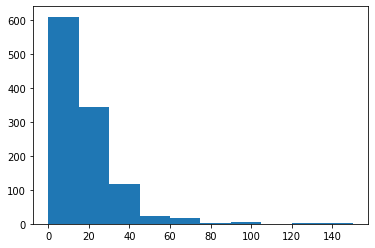

In [19]:
plt.hist(data_df1['tso'])

## 

## sorting categoricals & targets

In [20]:
targets = ['tst', 'tst_rem', 'tst_nrem', 'tso', 'totsleep', 'ess','p_eval_sleep', 'a_eval_slept', 'a_eval_hour',
       'a_eval_sleep', 'ps_eds', 'waso', 'se', 'sleepiness'
          ]

In [21]:
numerics = ['creatinine', 'glucose', 'hdl', 'ldl','total_cholesterol', 'triglycerides', 'uric_acid', 'weightkg', 'bmi',
       'headcm', 'waist_girth1', 'waist_girth2', 'hip_girth1', 'hip_girth2',
       'neck_girth1', 'neck_girth2', 'sit_sys1', 'sit_dia1', 'sit_sys2',
       'sit_dia2', 'hipgirthm', 'neckgirthm', 'waistgirthm', 'waisthip',
       'sitsysm', 'sitdiam', 'zung_score', 'zung_index', 'state',
       'trait', 'beer_week', 'wine_week', 'hard_week', 'bowls_day', 'packs_week', 'cigars_day',
       'smoke_years', 'pack_years','workday', 'weekend',
       'naps', 'snore_freq',
       'num_pregnancies', 'ahi',
       'minsao2tst', 'ptstl90', 'age', 'heightcm', 'cans_cola', 'cups_coffee',
       'caffeine', 'alcohol_wk','eval_general', 'eval_life','eval_health', 
       'snore_vol', 'choke_freq',
       'apnea_freq', 'awake_freq', 'ho_score'
           ]

In [22]:
categoricals = data_df1.drop(columns = numerics)
#categoricals = data_df1.drop(columns = targets)

In [23]:
ordinals = ['menopausal_status']

In [24]:
high_val_features = ['age',
 'weightkg',
 'bmi',
 'neck_girth1',
 'sit_sys1',
 'sit_dia1',
 'zung_score',
 'zung_index',
 'state',
 'trait',
 'caffeine',
 'hard_week',
 'alcohol_wk',
 'bowls_day',
 'packs_week',
 'cigars_day',
 'smoke_years',
 'pack_years',
 'eval_general',
 'eval_life',
 'eval_health',
 'workday',
 'weekend',
 'snore_freq',
 'snore_vol',
 'choke_freq',
 'apnea_freq']

In [25]:
#cross check high_val_features
data_df1[high_val_features]

,age,weightkg,bmi,neck_girth1,sit_sys1,sit_dia1,zung_score,zung_index,state,trait,...,pack_years,eval_general,eval_life,eval_health,workday,weekend,snore_freq,snore_vol,choke_freq,apnea_freq
wsc_id,,,,,,,,,,,,,,,,,,,,,
10119,52,85.5,27.6,39.5,112.0,78.0,24.0,30.00,20.0,24.0,...,0.000000,1,1,1,7.5,8.0,2.0,1,1,1
10191,50,73.0,25.3,31.5,132.0,84.0,31.0,38.75,27.4,24.0,...,0.000000,1,2,2,6.5,10.5,1.0,1,1,1
10198,57,115.5,46.9,39.5,142.0,88.0,30.0,37.50,25.3,28.0,...,47.142857,1,1,3,6.5,9.0,9.0,9,1,1
10226,55,79.2,26.5,39.5,128.0,76.0,34.0,42.50,37.9,36.0,...,78.000000,1,3,3,7.0,9.0,5.0,4,2,9
10241,51,100.6,34.4,42.0,140.0,88.0,31.0,38.75,21.1,25.0,...,1.142857,2,1,5,5.5,6.5,4.0,2,9,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99481,60,84.0,25.6,40.0,118.0,77.0,22.0,27.50,20.0,21.0,...,0.000000,1,1,2,6.0,8.0,2.0,2,1,1
99651,69,102.5,35.1,46.0,154.0,106.0,28.0,35.00,20.0,22.0,...,2.857143,1,1,2,7.0,7.0,5.0,4,9,9
99761,71,94.0,40.7,35.5,160.0,88.0,33.0,41.25,32.6,30.0,...,0.000000,1,1,2,7.5,9.0,5.0,3,9,9


## ac - TSO Linear Regression w/ Pipe

In [26]:
data_df1 = data_df1.fillna(0)

In [27]:
y = data_df1.tso
X = data_df1.drop(targets, axis=1)
X = data_df1.drop(categoricals, axis=1)

In [28]:
#X = data_df1[['snore_vol', 'choke_freq', 'apnea_freq', 'awake_freq']]

In [29]:
#X['target'] = y

In [30]:
#X.corr()

In [31]:
y.isna().sum().sum()

0

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, random_state=1)

In [33]:
scaler = RobustScaler()

In [34]:
linreg = LinearRegression()

In [35]:
pipe = Pipeline([('scaler', scaler),
                ('linereg', linreg)])

In [36]:
tso_lin_Reg = pipe.fit(X_train, y_train)

In [37]:
pipe.score(X_test, y_test,)

-3.3048764264477786

### Baseline with mean - using dummy regressor

In [38]:
data_df1 = data_df1[data_df1.tso < 80]
y = data_df1.tso
#X = data_df1.drop(targets, axis=1)
#X = data_df1.drop(categoricals, axis=1)

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, random_state=1)

ValueError: Found input variables with inconsistent numbers of samples: [1123, 1114]

In [40]:
y_pred = y_train.mean()

In [41]:
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_error

In [42]:
dummyr = DummyRegressor(strategy='mean')

In [43]:
dummyr.fit(X_train, y_train)

DummyRegressor()

In [44]:
# Baseline to beat
y_pred = dummyr.predict(X_test)

In [45]:
y_pred.shape

(281,)

In [46]:
mae_baseline = mean_absolute_error(y_test, y_pred)
mae_baseline

8.706211274629968

### Linear model with entire data set

In [47]:
data_df1 = data_df1[data_df1.tso < 80]

In [48]:
data_df1 = data_df1.fillna(0)

In [49]:
#data_df1['tso']

In [50]:
y = data_df1.tso
X = data_df1['waistgirthm','waist_girth2' ]
#X = data_df1.drop('tso', axis=1)
#X = data_df1.drop(targets, axis=1)
#X = data_df1.drop(categoricals, axis=1)

KeyError: ('waistgirthm', 'waist_girth2')

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, random_state=1)

ValueError: Found input variables with inconsistent numbers of samples: [1123, 1114]

In [52]:
scaler = MinMaxScaler()

In [53]:
linreg = LinearRegression()

In [54]:
pipe = Pipeline([('scaler', scaler),
                ('linereg', linreg)])

In [55]:
 pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', MinMaxScaler()), ('linereg', LinearRegression())])

In [56]:
y_pred_lin = pipe.predict(X_test)

In [57]:
mae_baseline = mean_absolute_error(y_test, y_pred_lin)
mae_baseline

11.473888752635574

### Feature permutation

In [58]:
from sklearn.inspection import permutation_importance

lin_model = LinearRegression().fit(X_train, y_train)

In [59]:
per_score = permutation_importance(lin_model,X_train, y_train, n_repeats=10)

In [60]:
type(per_score.importances)
per_score.importances_mean.shape

(60,)

In [61]:
importance_df = pd.DataFrame(np.vstack((X_train.columns, per_score.importances_mean)).T)

In [62]:
importance_df.columns=['feature','score decrease']

In [63]:
importance_df.sort_values(by='score decrease', ascending=False).head()

,feature,score decrease
24,waistgirthm,156.48001
13,waist_girth2,64.608661
22,hipgirthm,39.305115
12,waist_girth1,11.959329
15,hip_girth2,9.729744


### Linear Model with reduced X

In [64]:
y = data_df1.tso
X = data_df1[['waistgirthm','waist_girth2']]

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, random_state=1)

In [66]:
scaler = RobustScaler()

In [67]:
linreg = LinearRegression()

In [68]:
pipe = Pipeline([('scaler', scaler),
                ('linereg', linreg)])

In [69]:
 pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', RobustScaler()), ('linereg', LinearRegression())])

In [70]:
pipe.score(X_test, y_test)

0.00180039228253559

### Ridge model

In [71]:
from sklearn.linear_model import Ridge, Lasso, LinearRegression

In [72]:
y = data_df1.tso
X = data_df1.drop('tso', axis=1)
X = data_df1.drop(targets, axis=1)
X = data_df1.drop(categoricals, axis=1)

In [73]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, random_state=1)

In [74]:
linreg = LinearRegression().fit(X_train, y_train)
ridge = Ridge(alpha=0.2).fit(X_train, y_train)
lasso = Lasso(alpha=0.2).fit(X_train, y_train)



In [75]:
coefs = pd.DataFrame({
    "coef_linreg": pd.Series(linreg.coef_, index = X.columns),
    "coef_ridge": pd.Series(ridge.coef_, index = X.columns),
    "coef_lasso": pd.Series(lasso.coef_, index= X.columns)})\



In [76]:
coefs\
    .applymap(lambda x: int(x))\
    .style.applymap(lambda x: 'color: red' if x == 0 else 'color: black')

,coef_linreg,coef_ridge,coef_lasso
age,0,0,0
creatinine,0,0,0
glucose,0,0,0
hdl,0,0,0
ldl,0,0,0
total_cholesterol,0,0,0
triglycerides,0,0,0
uric_acid,0,0,0
heightcm,0,0,0
weightkg,0,0,0


## ac - TSO Linear Regression w/o Pipe

In [77]:
y = data_df1.tso
X = data_df1[high_val_features]


In [78]:
X.columns

Index(['age', 'weightkg', 'bmi', 'neck_girth1', 'sit_sys1', 'sit_dia1',
       'zung_score', 'zung_index', 'state', 'trait', 'caffeine', 'hard_week',
       'alcohol_wk', 'bowls_day', 'packs_week', 'cigars_day', 'smoke_years',
       'pack_years', 'eval_general', 'eval_life', 'eval_health', 'workday',
       'weekend', 'snore_freq', 'snore_vol', 'choke_freq', 'apnea_freq'],
      dtype='object')

In [79]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, random_state=1)

In [80]:
y_train.mean()

14.790419161676647

In [81]:
#X_train.select_dtypes(include=['float64', 'int64'])


In [82]:
X_train.columns

Index(['age', 'weightkg', 'bmi', 'neck_girth1', 'sit_sys1', 'sit_dia1',
       'zung_score', 'zung_index', 'state', 'trait', 'caffeine', 'hard_week',
       'alcohol_wk', 'bowls_day', 'packs_week', 'cigars_day', 'smoke_years',
       'pack_years', 'eval_general', 'eval_life', 'eval_health', 'workday',
       'weekend', 'snore_freq', 'snore_vol', 'choke_freq', 'apnea_freq'],
      dtype='object')

In [83]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [84]:
pd.DataFrame(X_train_scaled, columns=X_train.columns)

,age,weightkg,bmi,neck_girth1,sit_sys1,sit_dia1,zung_score,zung_index,state,trait,...,pack_years,eval_general,eval_life,eval_health,workday,weekend,snore_freq,snore_vol,choke_freq,apnea_freq
0,0.558125,1.606519,1.477723,1.213153,0.765938,-0.375106,-0.035044,-0.035044,-0.509630,-0.623293,...,-0.352981,-0.645329,-0.047909,0.820443,1.898330,1.077239,-0.777928,-1.020707,-0.759346,-0.701283
1,1.415482,1.421392,0.375769,1.213153,0.520896,-0.375106,0.550185,0.550185,0.401048,0.413413,...,-0.133117,-0.645329,-0.047909,0.820443,0.478994,0.248273,-1.221926,1.313421,-0.759346,-0.124650
2,2.150360,0.657747,0.527288,1.331285,0.030814,-1.797880,-1.351809,-1.351809,-1.072107,-1.429620,...,1.468746,-0.645329,-1.476636,-0.387793,0.952106,0.248273,-0.333929,-0.353813,1.660707,-0.701283
3,1.537962,0.356917,0.444642,2.276342,1.378541,1.047668,-1.059194,-1.059194,-1.072107,-1.084051,...,0.039633,-0.645329,-1.476636,-1.596028,0.005881,-0.580693,2.330061,1.646868,1.660707,1.605251
4,2.395319,-1.332360,-0.671086,-1.149489,2.113665,-0.781613,1.281722,1.281722,0.802817,0.067845,...,5.811052,-0.645329,-0.047909,-0.387793,0.952106,0.248273,-1.221926,-1.020707,-0.759346,1.605251
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
830,0.803085,-0.800122,-0.547117,0.149964,0.520896,1.250921,0.257571,0.257571,0.200163,1.565309,...,-0.510026,0.698436,1.380817,0.820443,-0.467231,-0.166210,0.110069,-0.687260,-0.154333,-0.701283
831,0.803085,-0.494664,-0.354275,0.504360,-0.826831,-0.781613,-0.620273,-0.620273,-0.509630,-1.314430,...,-0.510026,2.042200,-1.476636,-1.596028,1.425218,0.662756,0.554068,-0.687260,-0.154333,-0.124650
832,-0.789150,-0.175321,0.086507,-0.913225,0.030814,0.234654,0.257571,0.257571,0.200163,-0.047345,...,-0.510026,-0.645329,-0.047909,-0.387793,0.952106,0.248273,-0.777928,-1.020707,-0.759346,-0.701283
833,0.435646,-0.776981,-0.795056,-0.440696,0.153334,-0.375106,-1.205502,-1.205502,-0.924791,-0.738482,...,-0.510026,-0.645329,-0.047909,-0.387793,0.005881,0.248273,-0.777928,-0.687260,-0.759346,-0.701283


In [85]:
data_df1.tso.max(),data_df1.tso.min(), data_df1.tso.mean()

(75.0, 0.0, 14.736983842010773)

In [86]:
model = LinearRegression()

In [87]:
model.fit(X_train_scaled, y_train)

LinearRegression()

In [88]:
model.score(X_test_scaled, y_test)

-0.003496169327659837

In [89]:
#model.predict(X_test)
#model.coef_

## ac - Linear Regression with Cross validation


In [90]:
y = data_df1.tso
X = data_df1.drop('tso', axis=1)

In [91]:
y = data_df1.tso
X = data_df1.drop(targets, axis=1)
X = data_df1.drop(categoricals, axis=1)

In [92]:
cv_results = cross_validate(LinearRegression(), X,y, cv=5, scoring='neg_mean_absolute_error')
cv_results['test_score'].mean()

-10.196593363629637

In [93]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, random_state=1)

In [94]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

In [95]:
model = LinearRegression()

In [96]:
#cv_results = cross_validate(model, X_train_scaled,y_train, cv=5)

In [97]:
cv_results['test_score'].mean()

-10.196593363629637

## New Notebook

In [101]:
targs = ['tst_rem', 'tst_nrem', 'tso', 'totsleep', 'ess','p_eval_sleep', 'a_eval_slept', 'a_eval_hour',
       'a_eval_sleep', 'ps_eds', 'waso', 'se', 'sleepiness']

In [104]:
features_to_remove_2 = ['zung_score', 'hipgirthm', 'waistgirthm', 'waist_girth2', 'hip_girth2', 'sit_dia2', 'sitdiam', 'sit_sys2', 'sitsysm', 'neckgirthm', 'neck_girth2', 'ldl', 'bmi', 'caffeine', 'beer_week', 'wine_week', 'hard_week', 'pack_years', 'smoke_curr', 'smoke_quit', 'bowls_day', 'cigars_day', 'trait', 'state', 'glucose', 'thyroid_ynd', 'arrhythmia_ynd', 'arthritis_ynd', 'hypertension_ynd', 'htn_acei_med',  'htn_beta_med',  'htn_diuretic_med']

In [116]:
data_df1.drop(features_to_remove_2, axis=1)

,wsc_vst,sex,age,education_survey1,creatinine,hdl,total_cholesterol,triglycerides,uric_acid,heightcm,...,minsao2tst,ptstl90,x0_Hyperthyroid,x0_Hypothyroid,x0_Nodule,x0_Thyroid Cancer,x0_Unknown,x0_C,x0_N,x0_P
wsc_id,,,,,,,,,,,,,,,,,,,,,
10119,1,0,52,6.0,0.90,52.0,228.0,137.0,7.2,176,...,93.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10191,1,1,50,5.0,0.80,77.0,222.0,117.0,3.4,170,...,94.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
10198,1,1,57,4.0,0.90,48.0,211.0,85.0,5.9,157,...,87.2,0.7,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
10226,1,0,55,4.0,1.40,39.0,173.0,135.0,8.5,173,...,89.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10241,1,1,51,4.0,0.90,37.0,228.0,281.0,7.1,171,...,84.8,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99481,1,0,60,5.0,1.12,57.0,193.0,99.0,4.6,181,...,0.0,0.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
99651,1,0,69,5.0,1.40,36.0,184.0,181.0,7.7,171,...,76.9,2.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
99761,1,1,71,3.0,0.80,73.0,234.0,178.0,4.7,152,...,89.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
